In [1]:
import warnings

# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATASET = r'dataset\\Первичная выгрузка Станки Загрузка по дням.xlsx'

In [4]:
df = pd.read_excel(DATASET)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24291 entries, 0 to 24290
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Объект                                      24291 non-null  object        
 1   Дата                                        24290 non-null  datetime64[ns]
 2   Аварийная остановка, ч.                     24057 non-null  float64       
 3   Прогрев станка, ч.                          24057 non-null  float64       
 4   Серийное производство, ч.                   24057 non-null  float64       
 5   Отработка программы, ч.                     24057 non-null  float64       
 6   Ручной режим, ч.                            24057 non-null  float64       
 7   Станок под нагрузкой, ч.                    9239 non-null   float64       
 8   Программа выполняется, ч.                   24057 non-null  float64       
 9   Авария

In [6]:
df = df.iloc[:-1]

In [7]:
df['Аварийная остановка, ч.'] = df['Аварийная остановка, ч.'].astype(str).str.replace(',', '.').astype(float)

In [8]:
df_cleaned = df.dropna(subset=['Аварийная остановка, ч.'])

In [9]:
# import seaborn as sns
# sns.boxplot(x=df_cleaned['Аварийная остановка, ч.']);

In [10]:
# df_cleaned['Аварийная остановка, ч.'].describe()

In [11]:
# df.info()

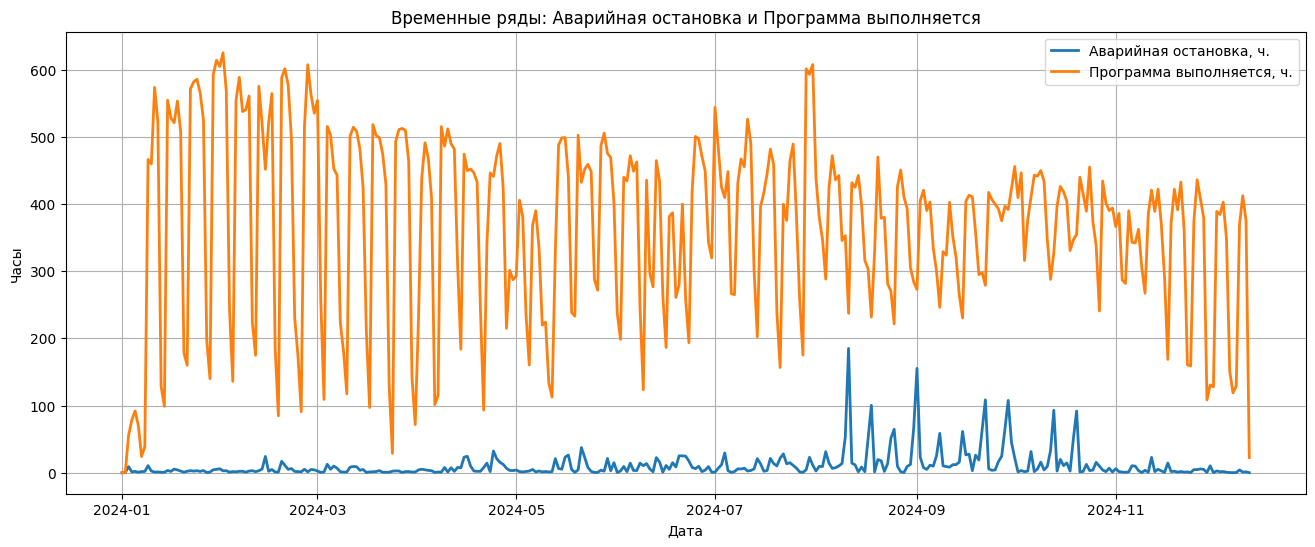

In [12]:
# # Преобразуем столбец "Дата" в формат datetime
# df['Дата'] = pd.to_datetime(df['Дата'])

# Агрегируем данные по дате (берем сумму значений по всем объектам)
df_aggregated = df.groupby('Дата')[['Аварийная остановка, ч.', 'Программа выполняется, ч.']].sum()

# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.", linewidth=2)
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(column):
    result = adfuller(column.dropna())
    p_value = result[1]

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    print(f"Used Lags: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    
    if p_value < 0.05:
        print(f'Ряд является стационарным')
    else:
        print(f'Ряд не является стационарным')

check_stationary(df_aggregated['Аварийная остановка, ч.'])
check_stationary(df_aggregated['Программа выполняется, ч.'])

ADF Statistic: -2.1844962124585563
p-value: 0.2119204789058649
Used Lags: 13
Number of Observations: 333
Critical Values:
   1%: -3.450141065277327
   5%: -2.870258846235788
   10%: -2.571415151457764
Ряд не является стационарным
ADF Statistic: -2.179162681641589
p-value: 0.21389492896947093
Used Lags: 14
Number of Observations: 332
Critical Values:
   1%: -3.4502011472639724
   5%: -2.8702852297358983
   10%: -2.5714292194077513
Ряд не является стационарным


In [14]:
df_aggregated['Аварийная остановка, ч.'] = df_aggregated['Аварийная остановка, ч.'].diff().dropna()
df_aggregated['Программа выполняется, ч.'] = df_aggregated['Программа выполняется, ч.'].diff().dropna()
check_stationary(df_aggregated['Аварийная остановка, ч.'])
check_stationary(df_aggregated['Программа выполняется, ч.'])

ADF Statistic: -9.065415143675626
p-value: 4.446407557448097e-15
Used Lags: 12
Number of Observations: 333
Critical Values:
   1%: -3.450141065277327
   5%: -2.870258846235788
   10%: -2.571415151457764
Ряд является стационарным
ADF Statistic: -7.539565999364586
p-value: 3.406454853194566e-11
Used Lags: 13
Number of Observations: 332
Critical Values:
   1%: -3.4502011472639724
   5%: -2.8702852297358983
   10%: -2.5714292194077513
Ряд является стационарным


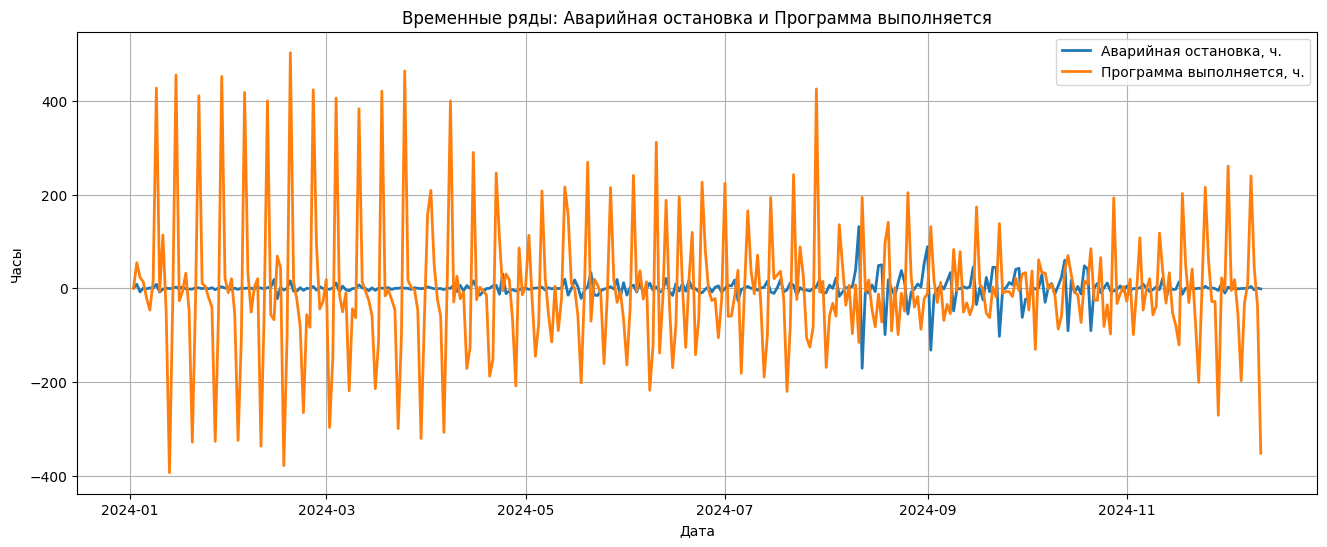

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.", linewidth=2)
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [17]:
def decompose_df(df, column_names, model='additive', period=30):
    for col in column_names:
        series = df[col].dropna()
        decompose_result = seasonal_decompose(series, model=model, period=period)

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"Сезонная декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()
        
def decompose_df_stl(df, column_names, seasonal=13, robust=False):
    for col in column_names:
        series = df[col].dropna()
        stl = STL(series, seasonal=seasonal, robust=robust)
        decompose_result = stl.fit()

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"STL-декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()

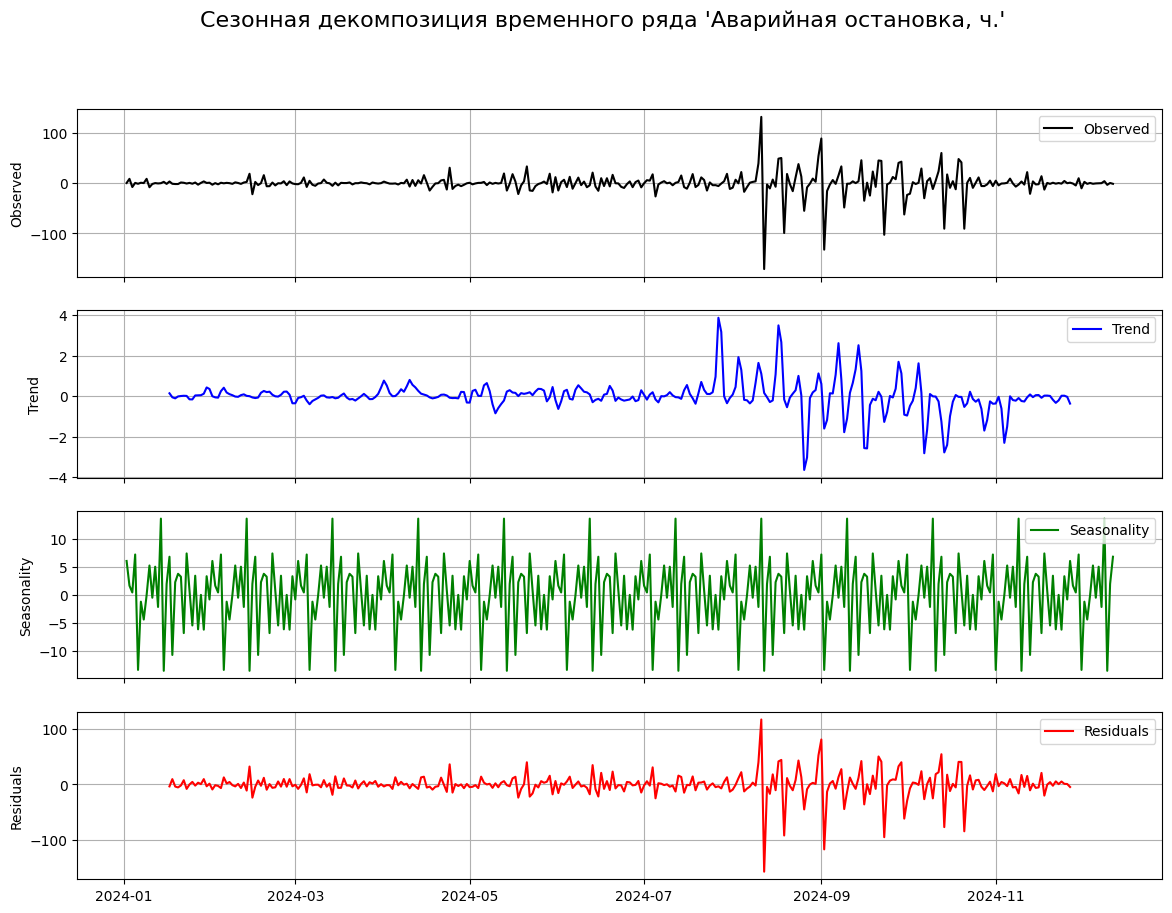

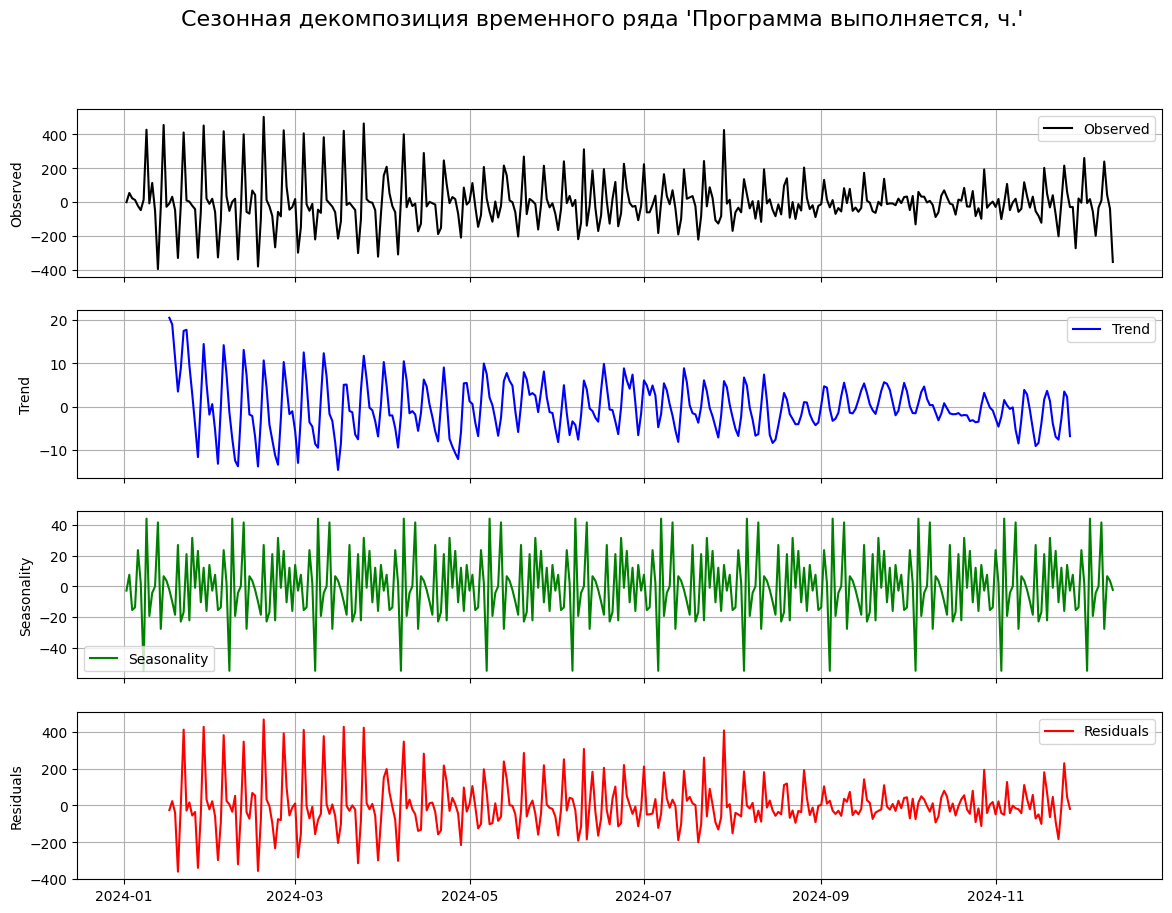

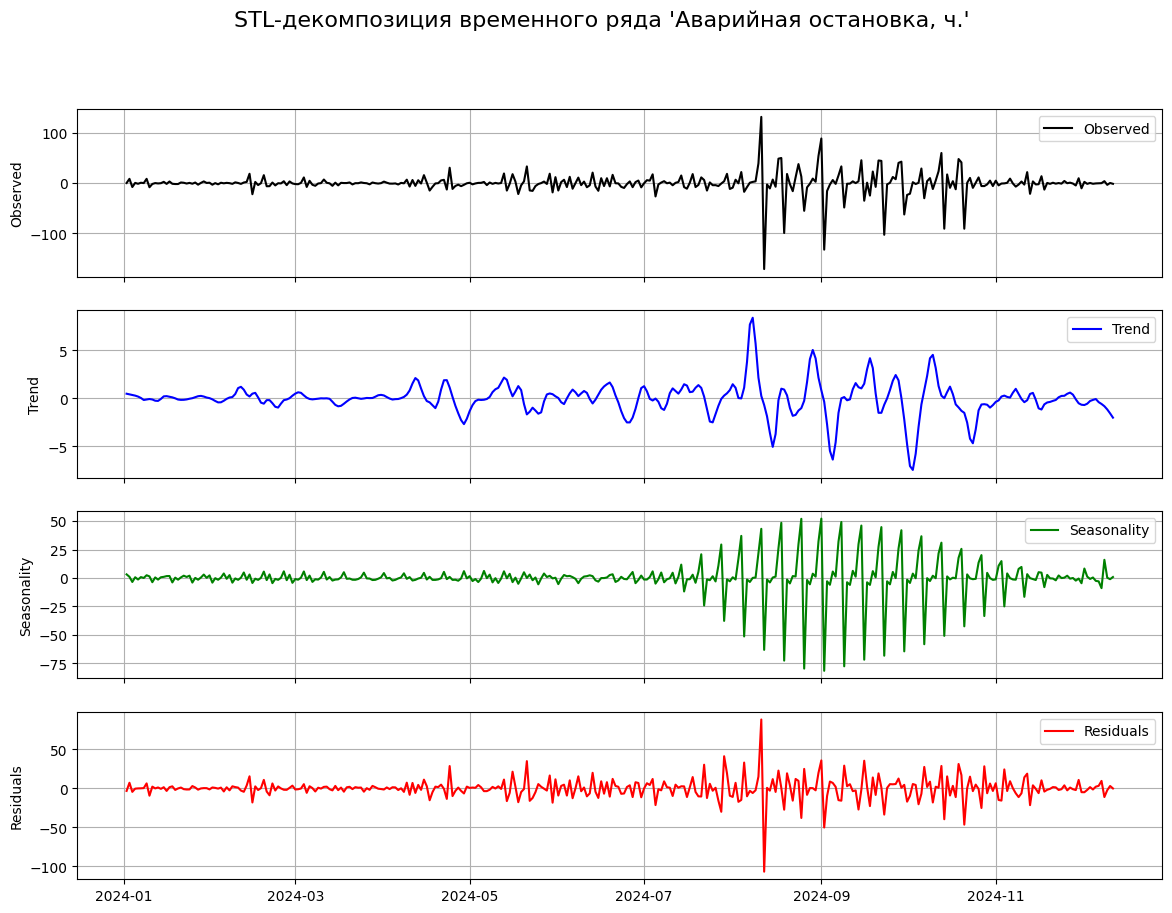

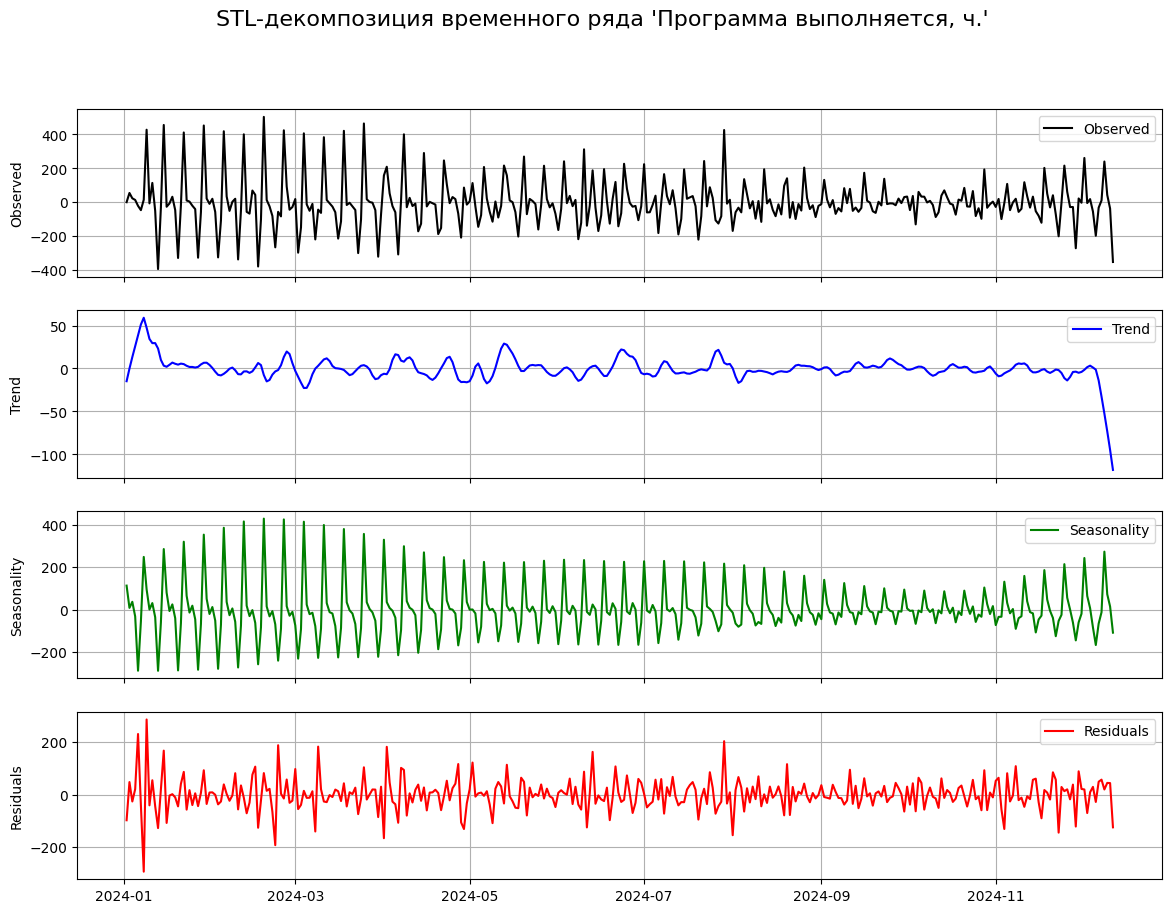

In [18]:
column_names = ["Аварийная остановка, ч.", "Программа выполняется, ч."]
decompose_df(df_aggregated, column_names)
decompose_df_stl(df_aggregated, column_names)

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def built_acf_and_pacf(df, column_names):
    for col in column_names:
        series = df[col].dropna()  # Берем только один столбец и удаляем NaN

        # Строим ACF и PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        plot_acf(series, lags=30, ax=axes[0])  # ACF для выбора q
        axes[0].set_title("ACF - Автокорреляция")

        plot_pacf(series, lags=30, ax=axes[1])  # PACF для выбора p
        axes[1].set_title("PACF - Частичная автокорреляция")

        # Добавляем общий заголовок
        fig.suptitle(f"ACF и PACF для '{col}'", fontsize=14)

        plt.show()  # Отображаем графики

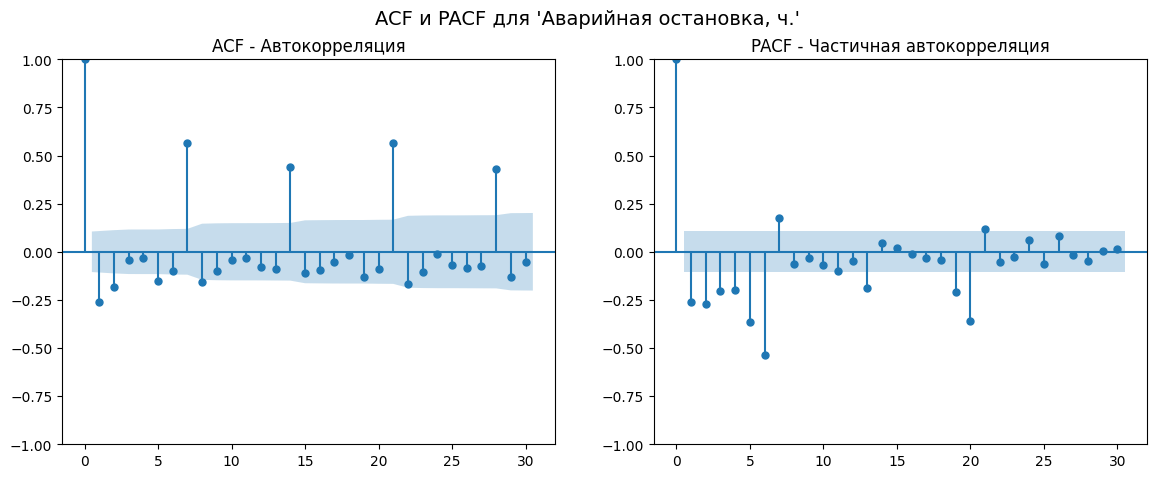

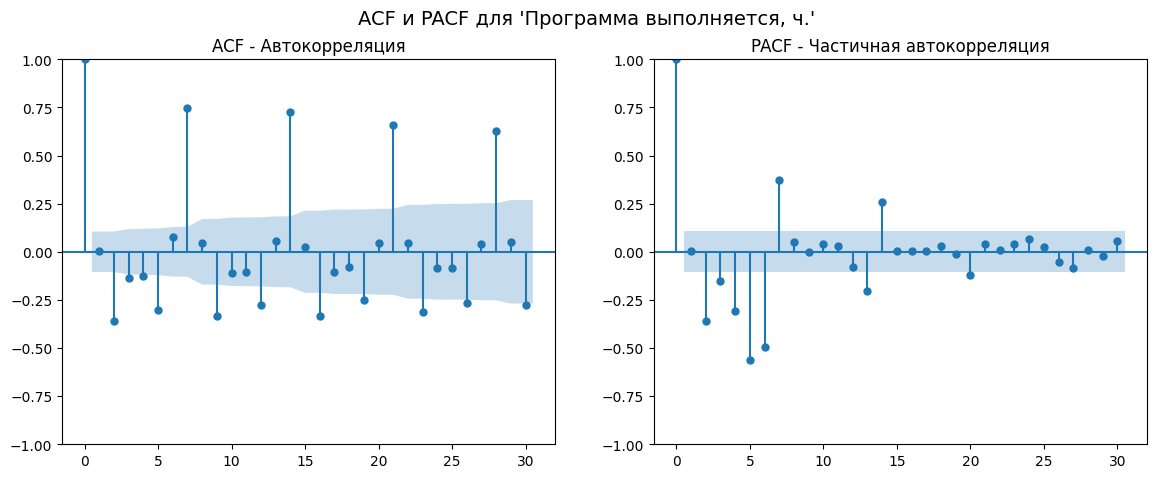

In [20]:
built_acf_and_pacf(df_aggregated, column_names)

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:           Аварийная остановка, ч.   No. Observations:                  347
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1402.923
Date:                           Fri, 17 Jan 2025   AIC                           2817.846
Time:                                   16:32:33   BIC                           2840.641
Sample:                               01-01-2024   HQIC                          2826.939
                                    - 12-12-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3649      0.033    -11.011      0.000      -0.430      -0.300
ar.L2         -0.2692      0.026    -10.178

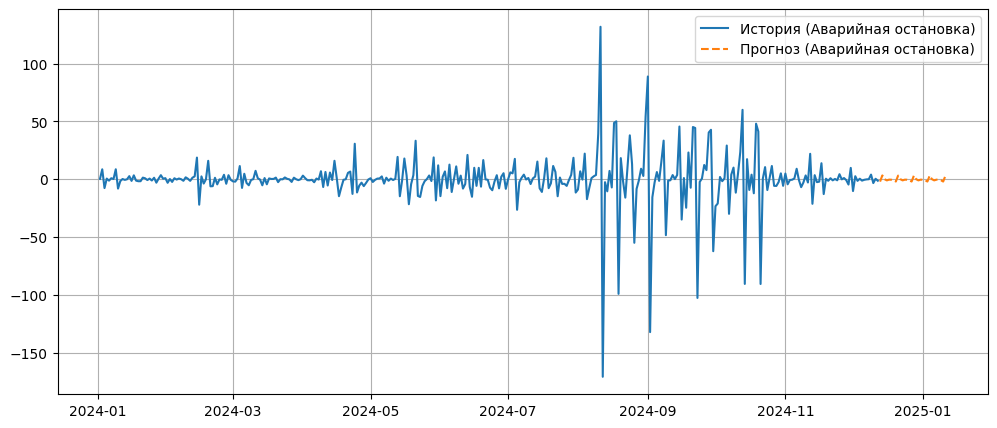

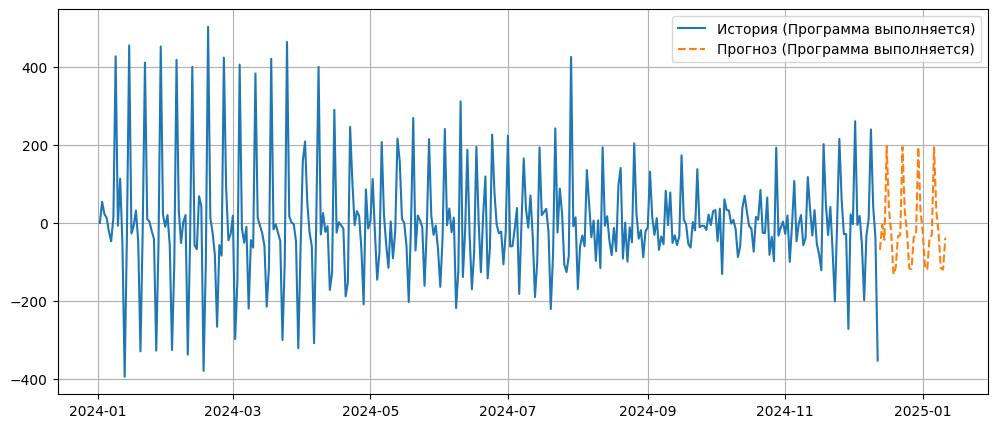

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Обучаем SARIMA для "Аварийная остановка, ч."
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=(2, 1, 1),  # (p, d, q)
                    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s)
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

# Обучаем SARIMA для "Программа выполняется, ч."
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=(2, 1, 1),
                      seasonal_order=(1, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Выводим краткие результаты
print(sarima_ao.summary())
print(sarima_prog.summary())

# Прогноз на следующий месяц (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Аварийная остановка, ч."], label="История (Аварийная остановка)")
plt.plot(forecast_ao, label="Прогноз (Аварийная остановка)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Программа выполняется, ч."], label="История (Программа выполняется)")
plt.plot(forecast_prog, label="Прогноз (Программа выполняется)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Разделяем данные на train и test (например, последние 30 дней для теста)
train_size = len(df_aggregated) - 30
train = df_aggregated.iloc[:train_size]
test = df_aggregated.iloc[train_size:]

# Обучаем SARIMA на train-данных
sarima_ao = SARIMAX(train["Аварийная остановка, ч."].dropna(),
                    order=(2,1,1),
                    seasonal_order=(1,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

sarima_prog = SARIMAX(train["Программа выполняется, ч."].dropna(),
                      order=(2,1,1),
                      seasonal_order=(1,1,1,7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Прогнозируем на тестовый период (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Убираем NaN из тестовых данных и прогноза
test_clean_ao = test["Аварийная остановка, ч."].dropna()
forecast_clean_ao = forecast_ao[:len(test_clean_ao)].dropna()

test_clean_prog = test["Программа выполняется, ч."].dropna()
forecast_clean_prog = forecast_prog[:len(test_clean_prog)].dropna()

# Пересчитываем метрики без NaN
mape_ao = mean_absolute_percentage_error(test_clean_ao, forecast_clean_ao)
mape_prog = mean_absolute_percentage_error(test_clean_prog, forecast_clean_prog)

rmse_ao = np.sqrt(mean_squared_error(test_clean_ao, forecast_clean_ao))
rmse_prog = np.sqrt(mean_squared_error(test_clean_prog, forecast_clean_prog))

# Выводим исправленные метрики
print(f"MAPE (Аварийная остановка): {mape_ao:.2%}")
print(f"RMSE (Аварийная остановка): {rmse_ao:.2f}")

print(f"MAPE (Программа выполняется): {mape_prog:.2%}")
print(f"RMSE (Программа выполняется): {rmse_prog:.2f}")



c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAPE (Аварийная остановка): 1669.53%
RMSE (Аварийная остановка): 10.51
MAPE (Программа выполняется): 227.82%
RMSE (Программа выполняется): 107.24


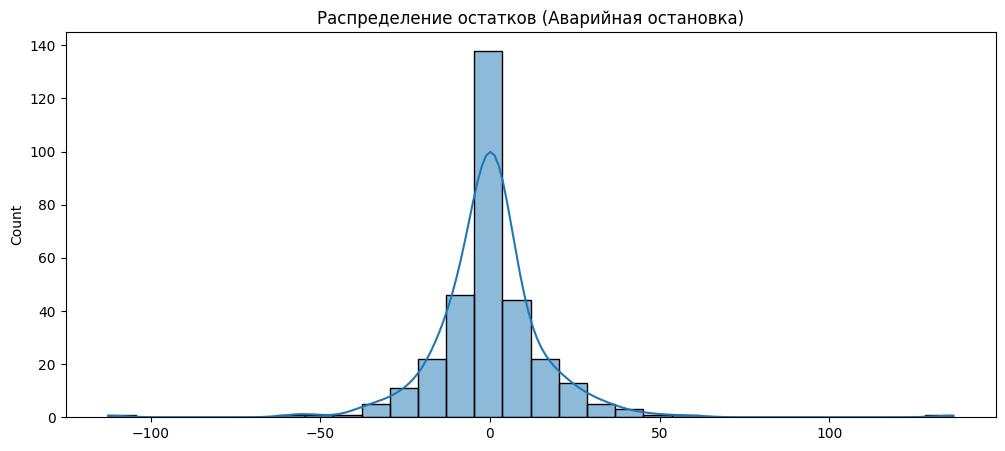

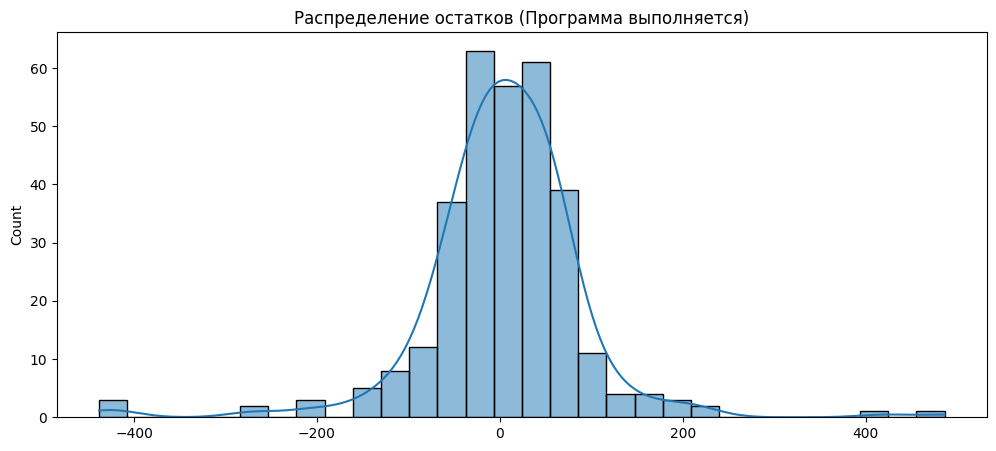

In [23]:
import seaborn as sns

# Остатки модели
residuals_ao = sarima_ao.resid
residuals_prog = sarima_prog.resid

# Гистограмма остатков
plt.figure(figsize=(12,5))
sns.histplot(residuals_ao, kde=True, bins=30)
plt.title("Распределение остатков (Аварийная остановка)")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(residuals_prog, kde=True, bins=30)
plt.title("Распределение остатков (Программа выполняется)")
plt.show()


<Figure size 1200x500 with 0 Axes>

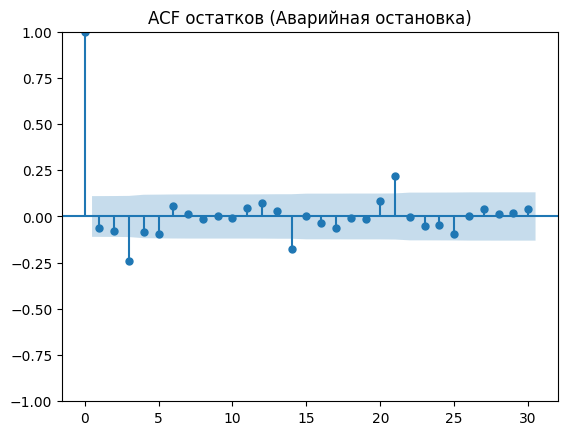

<Figure size 1200x500 with 0 Axes>

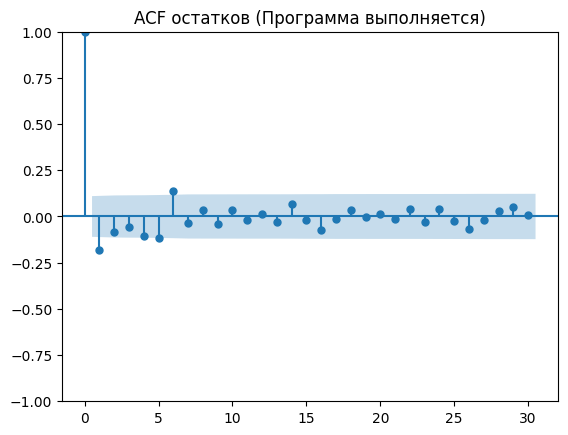

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,5))
plot_acf(residuals_ao.dropna(), lags=30)
plt.title("ACF остатков (Аварийная остановка)")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(residuals_prog.dropna(), lags=30)
plt.title("ACF остатков (Программа выполняется)")
plt.show()


In [25]:
import numpy as np

def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Применяем фильтр к обоим рядам
df_aggregated["Аварийная остановка, ч."] = remove_outliers_iqr(df_aggregated["Аварийная остановка, ч."])
df_aggregated["Программа выполняется, ч."] = remove_outliers_iqr(df_aggregated["Программа выполняется, ч."])


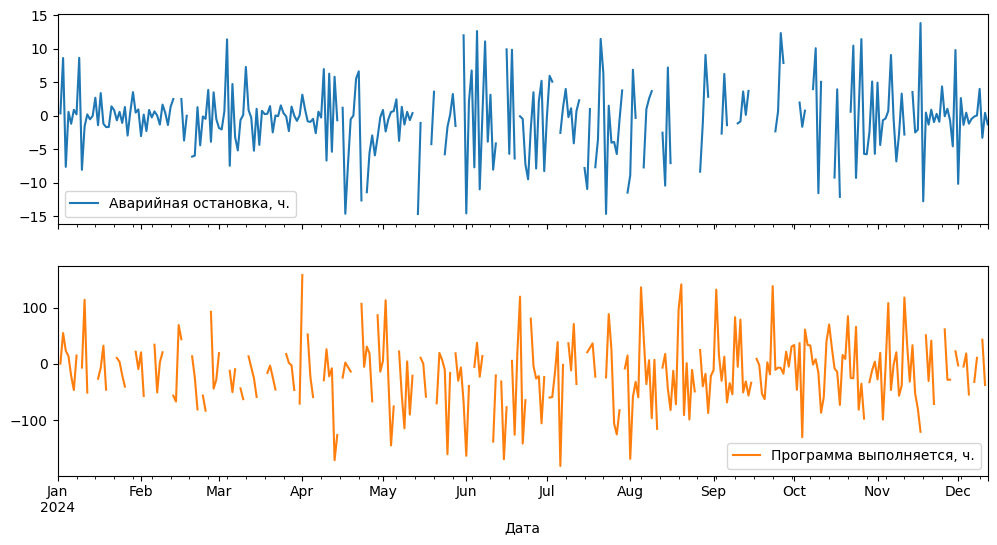

In [26]:
df_aggregated.plot(subplots=True, figsize=(12,6))
plt.show()


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:           Аварийная остановка, ч.   No. Observations:                  347
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -831.369
Date:                           Fri, 17 Jan 2025   AIC                           1674.737
Time:                                   16:32:36   BIC                           1697.532
Sample:                               01-01-2024   HQIC                          1683.830
                                    - 12-12-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3602      0.057     -6.274      0.000      -0.473      -0.248
ar.L2         -0.1783      0.062     -2.892

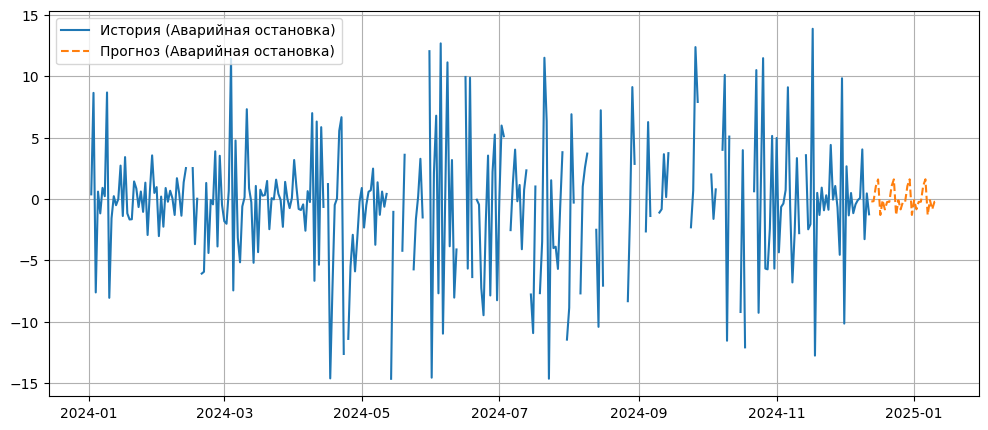

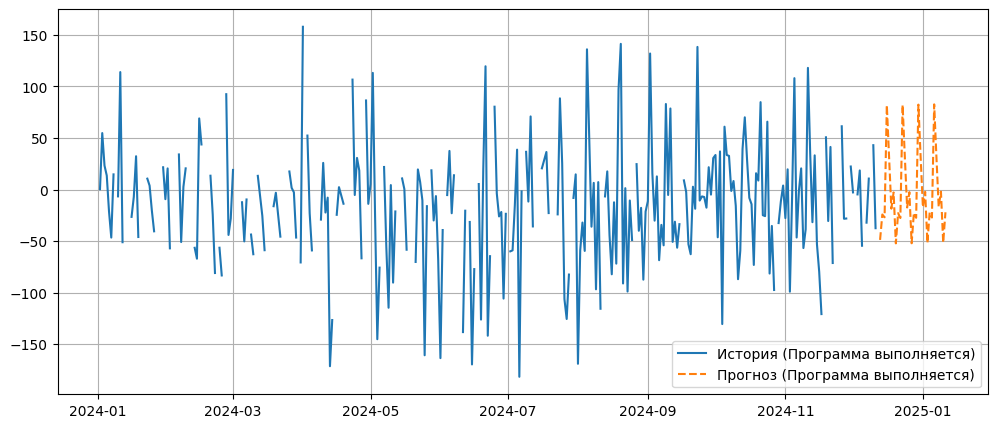

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Обучаем SARIMA для "Аварийная остановка, ч."
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=(2, 1, 1),  # (p, d, q)
                    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s)
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

# Обучаем SARIMA для "Программа выполняется, ч."
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=(2, 1, 1),
                      seasonal_order=(1, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Выводим краткие результаты
print(sarima_ao.summary())
print(sarima_prog.summary())

# Прогноз на следующий месяц (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Аварийная остановка, ч."], label="История (Аварийная остановка)")
plt.plot(forecast_ao, label="Прогноз (Аварийная остановка)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Программа выполняется, ч."], label="История (Программа выполняется)")
plt.plot(forecast_prog, label="Прогноз (Программа выполняется)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Разделяем данные на train и test (например, последние 30 дней для теста)
train_size = len(df_aggregated) - 30
train = df_aggregated.iloc[:train_size]
test = df_aggregated.iloc[train_size:]

# Обучаем SARIMA на train-данных
sarima_ao = SARIMAX(train["Аварийная остановка, ч."].dropna(),
                    order=(2,1,1),
                    seasonal_order=(1,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

sarima_prog = SARIMAX(train["Программа выполняется, ч."].dropna(),
                      order=(2,1,1),
                      seasonal_order=(1,1,1,7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Прогнозируем на тестовый период (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Убираем NaN из тестовых данных и прогноза
test_clean_ao = test["Аварийная остановка, ч."].dropna()
forecast_clean_ao = forecast_ao[:len(test_clean_ao)].dropna()

test_clean_prog = test["Программа выполняется, ч."].dropna()
forecast_clean_prog = forecast_prog[:len(test_clean_prog)].dropna()

# Пересчитываем метрики без NaN
mape_ao = mean_absolute_percentage_error(test_clean_ao, forecast_clean_ao)
mape_prog = mean_absolute_percentage_error(test_clean_prog, forecast_clean_prog)

rmse_ao = np.sqrt(mean_squared_error(test_clean_ao, forecast_clean_ao))
rmse_prog = np.sqrt(mean_squared_error(test_clean_prog, forecast_clean_prog))

# Выводим исправленные метрики
print(f"MAPE (Аварийная остановка): {mape_ao:.2%}")
print(f"RMSE (Аварийная остановка): {rmse_ao:.2f}")

print(f"MAPE (Программа выполняется): {mape_prog:.2%}")
print(f"RMSE (Программа выполняется): {rmse_prog:.2f}")

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

MAPE (Аварийная остановка): 210.43%
RMSE (Аварийная остановка): 4.94
MAPE (Программа выполняется): 123.99%
RMSE (Программа выполняется): 45.31


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


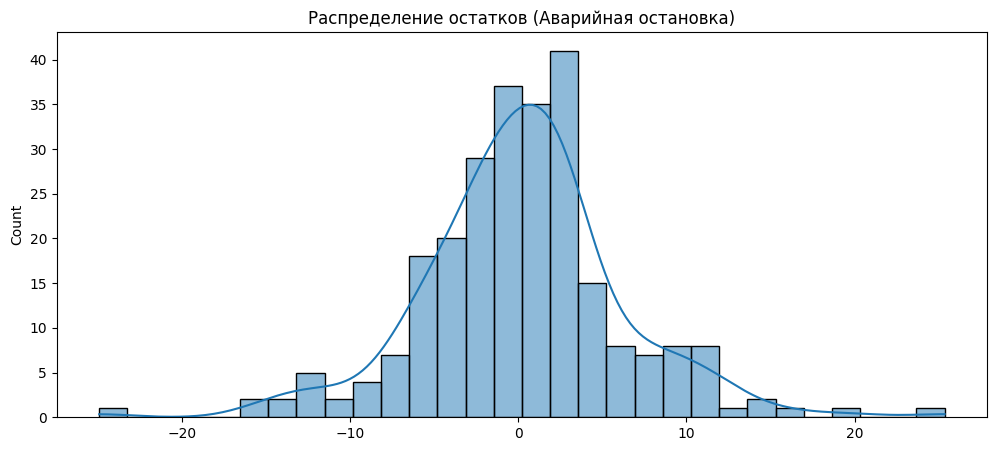

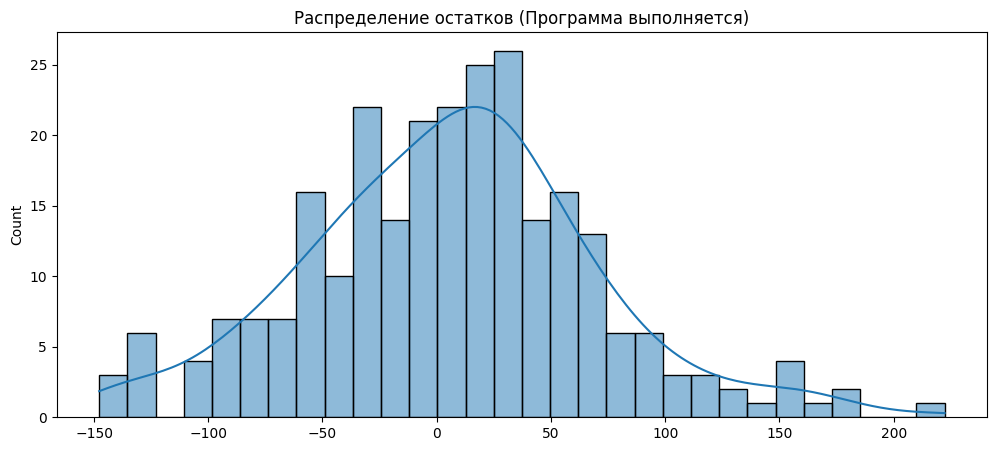

In [29]:
import seaborn as sns

# Остатки модели
residuals_ao = sarima_ao.resid
residuals_prog = sarima_prog.resid

# Гистограмма остатков
plt.figure(figsize=(12,5))
sns.histplot(residuals_ao, kde=True, bins=30)
plt.title("Распределение остатков (Аварийная остановка)")
plt.show();

plt.figure(figsize=(12,5))
sns.histplot(residuals_prog, kde=True, bins=30)
plt.title("Распределение остатков (Программа выполняется)")
plt.show();


<Figure size 1200x500 with 0 Axes>

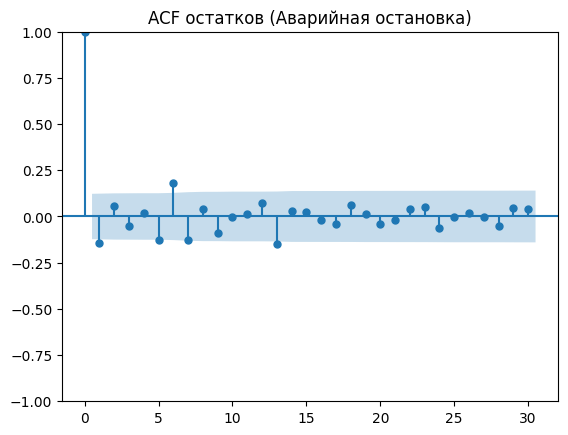

<Figure size 1200x500 with 0 Axes>

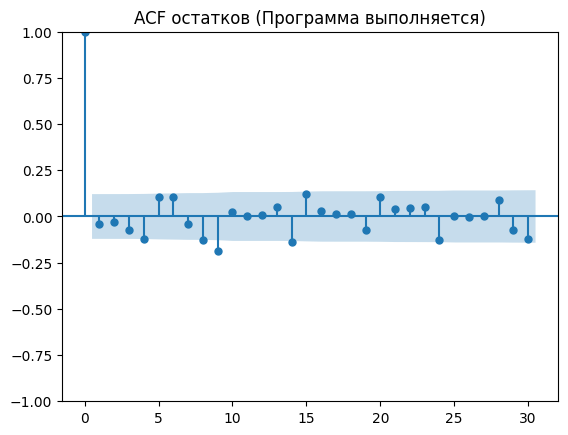

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,5))
plot_acf(residuals_ao.dropna(), lags=30)
plt.title("ACF остатков (Аварийная остановка)")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(residuals_prog.dropna(), lags=30)
plt.title("ACF остатков (Программа выполняется)")
plt.show()


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i

                                      SARIMAX Results                                      
Dep. Variable:             Аварийная остановка, ч.   No. Observations:                  347
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -828.150
Date:                             Fri, 17 Jan 2025   AIC                           1670.299
Time:                                     16:32:39   BIC                           1696.872
Sample:                                 01-01-2024   HQIC                          1680.900
                                      - 12-12-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6276      0.352     -1.785      0.074      -1.317       0.061
ar.L2         -0.2532      

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


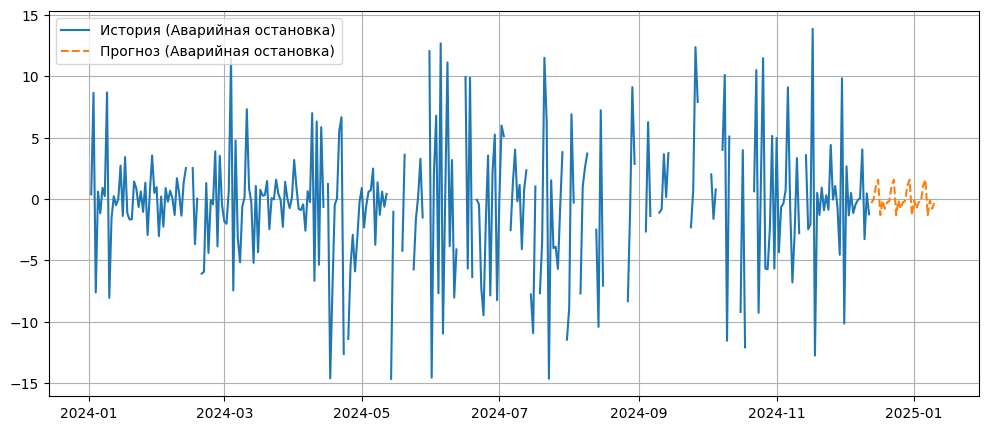

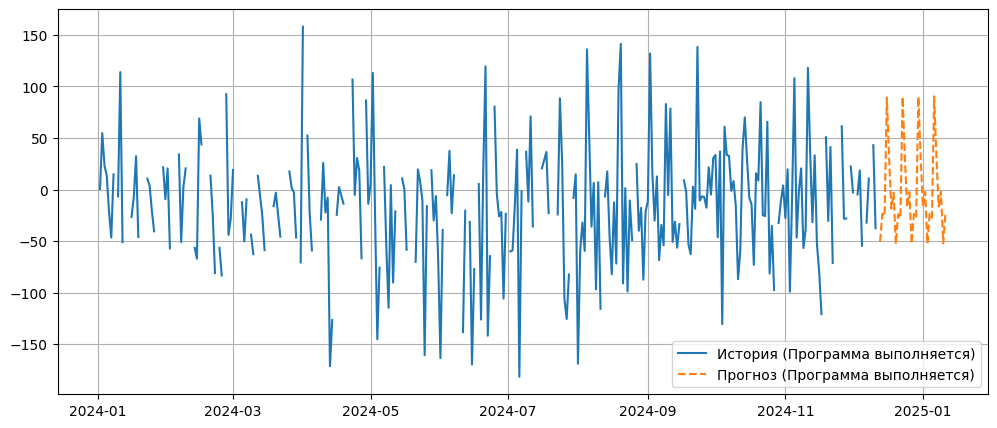

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Обучаем SARIMA для "Аварийная остановка, ч."
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=(2, 1, 2),  # (p, d, q)
                    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s)
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

# Обучаем SARIMA для "Программа выполняется, ч."
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=(2, 1, 2),
                      seasonal_order=(1, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Выводим краткие результаты
print(sarima_ao.summary())
print(sarima_prog.summary())

# Прогноз на следующий месяц (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Аварийная остановка, ч."], label="История (Аварийная остановка)")
plt.plot(forecast_ao, label="Прогноз (Аварийная остановка)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Программа выполняется, ч."], label="История (Программа выполняется)")
plt.plot(forecast_prog, label="Прогноз (Программа выполняется)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Разделяем данные на train и test (например, последние 30 дней для теста)
train_size = len(df_aggregated) - 30
train = df_aggregated.iloc[:train_size]
test = df_aggregated.iloc[train_size:]

# Обучаем SARIMA на train-данных
sarima_ao = SARIMAX(train["Аварийная остановка, ч."].dropna(),
                    order=(2,1,2),
                    seasonal_order=(1,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

sarima_prog = SARIMAX(train["Программа выполняется, ч."].dropna(),
                      order=(2,1,2),
                      seasonal_order=(1,1,1,7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Прогнозируем на тестовый период (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Убираем NaN из тестовых данных и прогноза
test_clean_ao = test["Аварийная остановка, ч."].dropna()
forecast_clean_ao = forecast_ao[:len(test_clean_ao)].dropna()

test_clean_prog = test["Программа выполняется, ч."].dropna()
forecast_clean_prog = forecast_prog[:len(test_clean_prog)].dropna()

# Пересчитываем метрики без NaN
mape_ao = mean_absolute_percentage_error(test_clean_ao, forecast_clean_ao)
mape_prog = mean_absolute_percentage_error(test_clean_prog, forecast_clean_prog)

rmse_ao = np.sqrt(mean_squared_error(test_clean_ao, forecast_clean_ao))
rmse_prog = np.sqrt(mean_squared_error(test_clean_prog, forecast_clean_prog))

# Выводим исправленные метрики
print(f"MAPE (Аварийная остановка): {mape_ao:.2%}")
print(f"RMSE (Аварийная остановка): {rmse_ao:.2f}")

print(f"MAPE (Программа выполняется): {mape_prog:.2%}")
print(f"RMSE (Программа выполняется): {rmse_prog:.2f}")

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

MAPE (Аварийная остановка): 209.70%
RMSE (Аварийная остановка): 4.94
MAPE (Программа выполняется): 124.73%
RMSE (Программа выполняется): 45.44


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


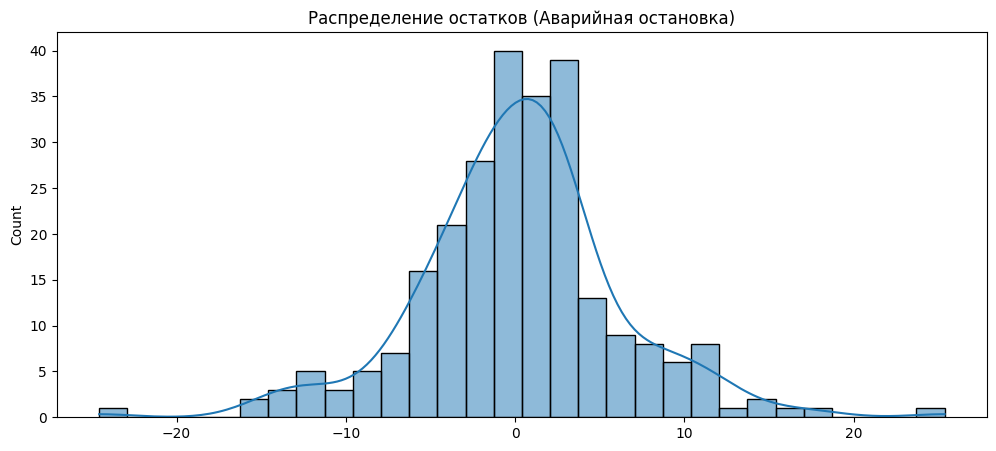

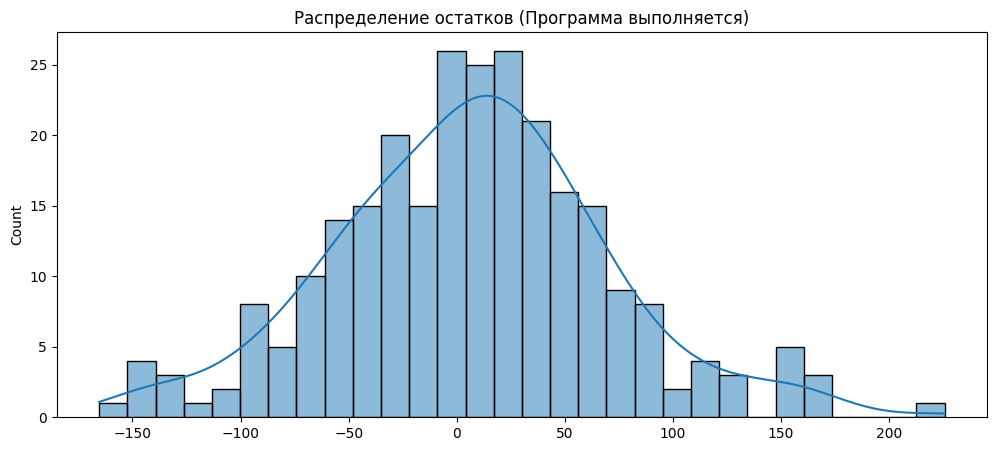

In [33]:
import seaborn as sns

# Остатки модели
residuals_ao = sarima_ao.resid
residuals_prog = sarima_prog.resid

# Гистограмма остатков
plt.figure(figsize=(12,5))
sns.histplot(residuals_ao, kde=True, bins=30)
plt.title("Распределение остатков (Аварийная остановка)")
plt.show();

plt.figure(figsize=(12,5))
sns.histplot(residuals_prog, kde=True, bins=30)
plt.title("Распределение остатков (Программа выполняется)")
plt.show();

<Figure size 1200x500 with 0 Axes>

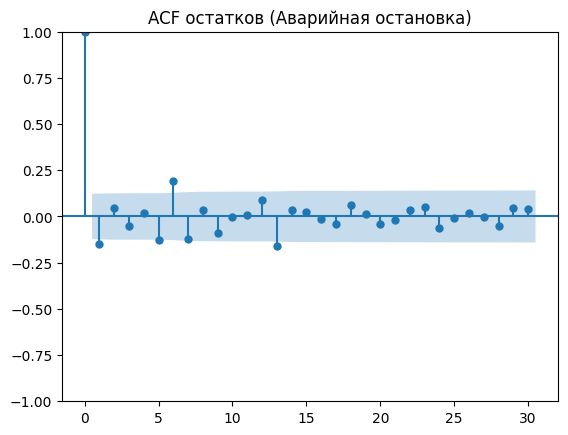

<Figure size 1200x500 with 0 Axes>

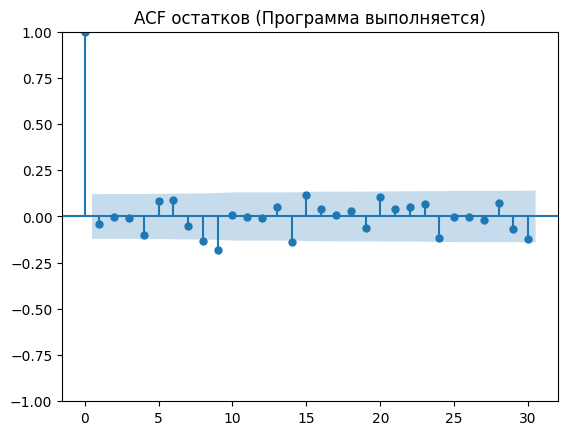

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,5))
plot_acf(residuals_ao.dropna(), lags=30)
plt.title("ACF остатков (Аварийная остановка)")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(residuals_prog.dropna(), lags=30)
plt.title("ACF остатков (Программа выполняется)")
plt.show()

In [35]:
df_aggregated[["Аварийная остановка, ч.", "Программа выполняется, ч."]].describe()

,"Аварийная остановка, ч.","Программа выполняется, ч."
count,284.000000,284.000000
mean,-0.452799,-18.308077
std,5.317094,59.882194
min,-14.667000,-181.603000
25%,-2.829250,-54.216000
50%,-0.099000,-15.621500
75%,1.594500,15.795750
max,13.865000,157.848000


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i

                                      SARIMAX Results                                      
Dep. Variable:             Аварийная остановка, ч.   No. Observations:                  347
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood                -825.292
Date:                             Fri, 17 Jan 2025   AIC                           1666.585
Time:                                     16:32:43   BIC                           1696.929
Sample:                                 01-01-2024   HQIC                          1678.691
                                      - 12-12-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6387      0.369     -1.731      0.083      -1.362       0.085
ar.L2         -0.2254      

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


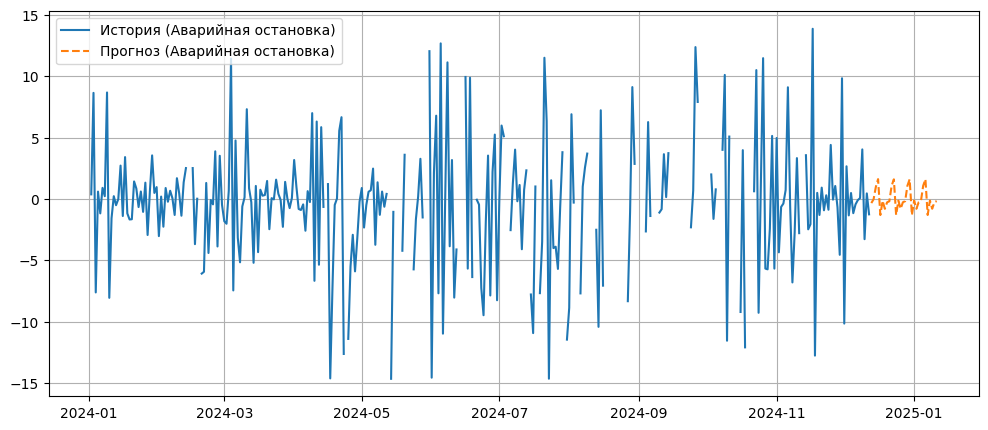

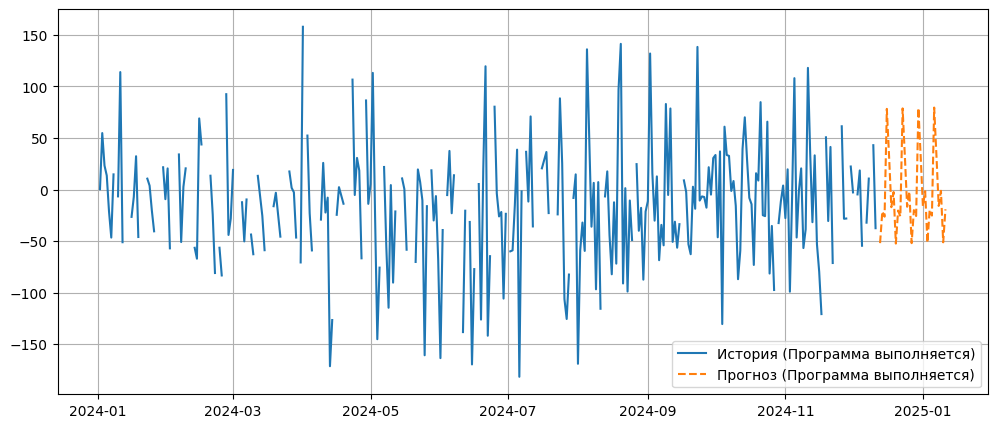

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Обучаем SARIMA для "Аварийная остановка, ч."
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=(2, 1, 3),  # (p, d, q)
                    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s)
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

# Обучаем SARIMA для "Программа выполняется, ч."
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=(2, 1, 3),
                      seasonal_order=(1, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Выводим краткие результаты
print(sarima_ao.summary())
print(sarima_prog.summary())

# Прогноз на следующий месяц (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Аварийная остановка, ч."], label="История (Аварийная остановка)")
plt.plot(forecast_ao, label="Прогноз (Аварийная остановка)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df_aggregated["Программа выполняется, ч."], label="История (Программа выполняется)")
plt.plot(forecast_prog, label="Прогноз (Программа выполняется)", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Разделяем данные на train и test (например, последние 30 дней для теста)
train_size = len(df_aggregated) - 30
train = df_aggregated.iloc[:train_size]
test = df_aggregated.iloc[train_size:]

# Обучаем SARIMA на train-данных
sarima_ao = SARIMAX(train["Аварийная остановка, ч."].dropna(),
                    order=(2,1,3),
                    seasonal_order=(3,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

sarima_prog = SARIMAX(train["Программа выполняется, ч."].dropna(),
                      order=(2,1,3),
                      seasonal_order=(1,1,1,7),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()

# Прогнозируем на тестовый период (30 дней)
forecast_ao = sarima_ao.forecast(steps=30)
forecast_prog = sarima_prog.forecast(steps=30)

# Убираем NaN из тестовых данных и прогноза
test_clean_ao = test["Аварийная остановка, ч."].dropna()
forecast_clean_ao = forecast_ao[:len(test_clean_ao)].dropna()

test_clean_prog = test["Программа выполняется, ч."].dropna()
forecast_clean_prog = forecast_prog[:len(test_clean_prog)].dropna()

# Пересчитываем метрики без NaN
mape_ao = mean_absolute_percentage_error(test_clean_ao, forecast_clean_ao)
mape_prog = mean_absolute_percentage_error(test_clean_prog, forecast_clean_prog)

rmse_ao = np.sqrt(mean_squared_error(test_clean_ao, forecast_clean_ao))
rmse_prog = np.sqrt(mean_squared_error(test_clean_prog, forecast_clean_prog))

# Выводим исправленные метрики
print(f"MAPE (Аварийная остановка): {mape_ao:.2%}")
print(f"RMSE (Аварийная остановка): {rmse_ao:.2f}")

print(f"MAPE (Программа выполняется): {mape_prog:.2%}")
print(f"RMSE (Программа выполняется): {rmse_prog:.2f}")

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

MAPE (Аварийная остановка): 231.04%
RMSE (Аварийная остановка): 4.94
MAPE (Программа выполняется): 119.78%
RMSE (Программа выполняется): 44.17


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
from pmdarima import auto_arima

# Убираем NaN перед передачей данных в auto_arima
series_ao = df_aggregated["Аварийная остановка, ч."].dropna()
series_prog = df_aggregated["Программа выполняется, ч."].dropna()

# Запускаем auto_arima на очищенных данных
auto_arima_ao = auto_arima(series_ao, seasonal=True, m=7)
auto_arima_prog = auto_arima(series_prog, seasonal=True, m=7)

# Выводим результаты
print(auto_arima_ao.summary())
print(auto_arima_prog.summary())



                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  284
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 7)   Log Likelihood                -865.944
Date:                            Fri, 17 Jan 2025   AIC                           1739.887
Time:                                    16:33:41   BIC                           1754.483
Sample:                                         0   HQIC                          1745.739
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3816      0.227     -1.680      0.093      -0.827       0.064
ma.L1         -0.2510      0.048   

In [40]:
sarima_ao = SARIMAX(df_aggregated["Аварийная остановка, ч."], 
                    order=(0, 1, 1),
                    seasonal_order=(1, 0, 0, 7)).fit()
print(sarima_ao.summary())


                                     SARIMAX Results                                      
Dep. Variable:            Аварийная остановка, ч.   No. Observations:                  347
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood                -885.035
Date:                            Fri, 17 Jan 2025   AIC                           1776.070
Time:                                    16:35:20   BIC                           1787.610
Sample:                                01-01-2024   HQIC                          1780.665
                                     - 12-12-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.204     -4.908      0.000      -1.399      -0.600
ar.S.L7       -0.0223      0.066   

c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [41]:
sarima_prog = SARIMAX(df_aggregated["Программа выполняется, ч."], 
                      order=(0, 1, 2),
                      seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_prog.summary())


c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\stanki\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:           Программа выполняется, ч.   No. Observations:                  347
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -1480.012
Date:                             Fri, 17 Jan 2025   AIC                           2970.023
Time:                                     16:35:31   BIC                           2989.153
Sample:                                 01-01-2024   HQIC                          2977.647
                                      - 12-12-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1836      0.077    -15.358      0.000      -1.335      -1.033
ma.L2          0.1870      